In [1]:
from __future__ import print_function
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from collections import defaultdict, OrderedDict
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, mean_absolute_error, matthews_corrcoef
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import pandas as pd
import time

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore all warnings
warnings.filterwarnings('ignore')

# Build dataset

In [2]:
store = pd.HDFStore('../ukdale/ukdale.h5', mode='r')

In [3]:
def resample_meter(store=None, building=1, meter=1, period='1min', cutoff=1000.):
    key = '/building{}/elec/meter{}'.format(building,meter)
    m = store[key]
    v = m.values.flatten()
    t = m.index
    s = pd.Series(v, index=t).clip(0.,cutoff)
    s[s<10.] = 0.
    return s.resample('1s').ffill(limit=300).fillna(0.).resample(period).mean().tz_convert('UTC')

In [4]:
def get_series(datastore, house, label, cutoff):
    filename = '../ukdale/house_%1d_labels.dat' %house
    print(filename)
    labels = pd.read_csv(filename, delimiter=' ', header=None, index_col=0).to_dict()[1]

    for i in labels:
        if labels[i] == label:
            print(i, labels[i])
            s = resample_meter(store, house, i, '1min', cutoff)
            #s = resample_meter(store, house, i, '6s', cutoff)

    s.index.name = 'datetime'
    
    return s

In [5]:
house = 1
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'

ds_1 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_1.fillna(method='pad', inplace=True)

ds_1_train = ds_1[pd.to_datetime('2013-04-12 00:00:00+00:00'):pd.to_datetime('2014-12-15 00:00:00+00:00')]
ds_1_valid = ds_1[pd.to_datetime('2014-12-15 00:00:00+00:00'):]


../ukdale/house_1_labels.dat
1 aggregate
../ukdale/house_1_labels.dat
10 kettle
../ukdale/house_1_labels.dat
12 fridge
../ukdale/house_1_labels.dat
5 washing_machine
../ukdale/house_1_labels.dat
13 microwave
../ukdale/house_1_labels.dat
6 dishwasher


In [6]:
house = 2
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dish_washer', 2500.)
a5.name = 'dish_washer'

ds_2 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_2.fillna(method='pad', inplace=True)

ds_2_train = ds_2[pd.to_datetime('2013-05-22 00:00:00+00:00'):pd.to_datetime('2013-10-03 00:00:00+00:00')]
ds_2_valid = ds_2[pd.to_datetime('2013-10-03 00:00:00+00:00'):]

../ukdale/house_2_labels.dat
1 aggregate
../ukdale/house_2_labels.dat
8 kettle
../ukdale/house_2_labels.dat
14 fridge
../ukdale/house_2_labels.dat
12 washing_machine
../ukdale/house_2_labels.dat
15 microwave
../ukdale/house_2_labels.dat
13 dish_washer


In [7]:
house = 3
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = 0.*m
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'
    
ds_3 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_3.fillna(method='pad', inplace=True)

ds_3_train = ds_3[pd.to_datetime('2013-02-27 00:00:00+00:00'):pd.to_datetime('2013-04-01 00:00:00+00:00')]
ds_3_valid = ds_3[pd.to_datetime('2013-04-01 00:00:00+00:00'):]


../ukdale/house_3_labels.dat
1 aggregate
../ukdale/house_3_labels.dat
2 kettle


In [8]:
house = 4
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle_radio', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'freezer', 300.)
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'

ds_4 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_4.fillna(method='pad', inplace=True)

ds_4_train = ds_4[pd.to_datetime('2013-03-09 00:00:00+00:00'):pd.to_datetime('2013-09-24 00:00:00+00:00')]
ds_4_valid = ds_4[pd.to_datetime('2013-09-24 00:00:00+00:00'):]

../ukdale/house_4_labels.dat
1 aggregate
../ukdale/house_4_labels.dat
3 kettle_radio
../ukdale/house_4_labels.dat
5 freezer


In [9]:
house = 5
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge_freezer', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washer_dryer', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
    
ds_5 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_5.fillna(method='pad', inplace=True)

ds_5_train = ds_5[pd.to_datetime('2014-06-29 00:00:00+00:00'):pd.to_datetime('2014-09-1 00:00:00+00:00')]
ds_5_valid = ds_5[pd.to_datetime('2014-09-1 00:00:00+00:00'):]

../ukdale/house_5_labels.dat
1 aggregate
../ukdale/house_5_labels.dat
18 kettle
../ukdale/house_5_labels.dat
19 fridge_freezer
../ukdale/house_5_labels.dat
24 washer_dryer
../ukdale/house_5_labels.dat
23 microwave
../ukdale/house_5_labels.dat
22 dishwasher


In [10]:
ds_1_train.reset_index().to_feather('../UKDALE_1_train.feather')
ds_2_train.reset_index().to_feather('../UKDALE_2_train.feather')
ds_3_train.reset_index().to_feather('../UKDALE_3_train.feather')
ds_4_train.reset_index().to_feather('../UKDALE_4_train.feather')
ds_5_train.reset_index().to_feather('../UKDALE_5_train.feather')

ds_1_valid.reset_index().to_feather('../UKDALE_1_valid.feather')
ds_2_valid.reset_index().to_feather('../UKDALE_2_valid.feather')
ds_3_valid.reset_index().to_feather('../UKDALE_3_valid.feather')
ds_4_valid.reset_index().to_feather('../UKDALE_4_valid.feather')
ds_5_valid.reset_index().to_feather('../UKDALE_5_valid.feather')

In [11]:
# Read the feather dataframe resampled

In [12]:
def get_status(app, threshold, min_off, min_on):
    condition = app > threshold
    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    on_events = idx[:,0].copy()
    off_events = idx[:,1].copy()
    assert len(on_events) == len(off_events)

    if len(on_events) > 0:
        off_duration = on_events[1:] - off_events[:-1]
        off_duration = np.insert(off_duration, 0, 1000.)
        on_events = on_events[off_duration > min_off]
        off_events = off_events[np.roll(off_duration, -1) > min_off]
        assert len(on_events) == len(off_events)

        on_duration = off_events - on_events
        on_events = on_events[on_duration > min_on]
        off_events = off_events[on_duration > min_on]

    s = app.copy()
    #s.iloc[:] = 0.
    s[:] = 0.

    for on, off in zip(on_events, off_events):
        #s.iloc[on:off] = 1.
        s[on:off] = 1.
    
    return s

In [13]:
class Power(data.Dataset):
    def __init__(self, meter=None, appliance=None, status=None, 
                 length=256, border=680, max_power=1., train=False):
        self.length = length
        self.border = border
        self.max_power = max_power
        self.train = train

        self.meter = meter.copy()/self.max_power
        self.appliance = appliance.copy()/self.max_power
        self.status = status.copy()

        self.epochs = (len(self.meter) - 2*self.border) // self.length

    def __getitem__(self, index):
        i = index * self.length + self.border
        if self.train:
            i = np.random.randint(self.border, len(self.meter) - self.length - self.border)

        x = self.meter.iloc[i-self.border:i+self.length+self.border].values.astype('float32')
        y = self.appliance.iloc[i:i+self.length].values.astype('float32')
        s = self.status.iloc[i:i+self.length].values.astype('float32')

        return x, y, s

    def __len__(self):
        return self.epochs
    
    def denormalize(self):
        self.meter *= self.max_power
        self.appliance *= self.max_power

In [14]:
class Encoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=3, padding=1, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=kernel_size, padding=padding, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))

class TemporalPooling(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2):
        super(TemporalPooling, self).__init__()
        self.kernel_size = kernel_size
        self.pool = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.kernel_size)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, padding=0)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(F.relu(x))
        return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='linear', align_corners=True))

class AttentionBlock(nn.Module):
    def __init__(self, in_features):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_features, in_features // 8, kernel_size=1)
        self.conv2 = nn.Conv1d(in_features // 8, in_features, kernel_size=1)

    def forward(self, x):
        attention = torch.sigmoid(self.conv2(F.relu(self.conv1(x))))
        return x * attention

class Decoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2, stride=2):
        super(Decoder, self).__init__()
        self.conv = nn.ConvTranspose1d(in_features, out_features, kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        return F.relu(self.conv(x))

class PTPNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(PTPNet, self).__init__()
        p = 2
        k = 1
        features = init_features
        self.encoder1 = Encoder(in_channels, features, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder2 = Encoder(features * 1**k, features * 2**k, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder3 = Encoder(features * 2**k, features * 4**k, kernel_size=3, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder4 = Encoder(features * 4**k, features * 8**k, kernel_size=3, padding=0)
        
        self.tpool1 = TemporalPooling(features*8**k, features*2**k, kernel_size=5)
        self.tpool2 = TemporalPooling(features*8**k, features*2**k, kernel_size=10)
        self.tpool3 = TemporalPooling(features*8**k, features*2**k, kernel_size=20)
        self.tpool4 = TemporalPooling(features*8**k, features*2**k, kernel_size=30)
        
        self.attention = AttentionBlock(features * 8**k)

        self.decoder = Decoder(2*features * 8**k, features * 1**k, kernel_size=p**3, stride=p**3)

        self.activation = nn.Conv1d(features * 1**k, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        tp1 = self.tpool1(enc4)
        tp2 = self.tpool2(enc4)
        tp3 = self.tpool3(enc4)
        tp4 = self.tpool4(enc4)

        enc4 = self.attention(enc4)  # Apply attention

        dec = self.decoder(torch.cat([enc4, tp1, tp2, tp3, tp4], dim=1))

        act = self.activation(dec)
        return act

x = torch.randn(32, 1, 60 * 8 + 2 * 16)
model = PTPNet(1, 3, 32)

print(x)

print(model(x).shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

tensor([[[-1.7874, -1.2992,  1.3785,  ..., -0.1523, -0.3319,  0.3606]],

        [[ 0.8265, -0.3129, -1.1792,  ...,  0.2519,  1.0007, -0.3182]],

        [[ 0.5354,  0.6992,  2.2951,  ..., -0.0664, -0.8703, -0.3926]],

        ...,

        [[-0.1458,  0.5704, -1.3410,  ..., -0.9180,  0.3614,  0.8789]],

        [[-0.9260, -1.2657, -1.3213,  ..., -0.8511, -0.7962,  0.7856]],

        [[ 0.1220, -0.6295,  1.3642,  ..., -2.2387,  0.1573, -0.5841]]])
torch.Size([32, 3, 480])
344291


In [15]:
def train_model(model, batch_size, n_epochs, filename):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the test loss as the model trains
    test_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    # to track the average test loss per epoch as the model trains
    avg_test_losses = [] 
    
    min_loss = np.inf
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target_power, target_status) in enumerate(train_loader, 1):
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output_power = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_power, target_power)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target_power, target_status in valid_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output_power = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_power, target_power)
            # record validation loss
            valid_losses.append(loss.item())

        ##################    
        # test the model #
        ##################
        model.eval() # prep model for evaluation
        for data, target_power, target_status in test_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output_power = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_power, target_power)
            # record validation loss
            test_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        test_loss = np.average(test_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_test_losses.append(test_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'test_loss: {test_loss:.5f} ')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        test_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        #early_stopping(valid_loss, model)
        #if (early_stopping.early_stop and (epoch > 80)):
        #    break
        
        if valid_loss < min_loss:
            print(f'Validation loss decreased ({min_loss:.6f} --> {valid_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), filename)
            min_loss = valid_loss
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(filename))
    
    return  model, avg_train_losses, avg_valid_losses, avg_test_losses

In [16]:
def evaluate_power(model, loader, a):
    x_true = []
    s_true = []
    p_true = []
    p_hat = []
    
    model.eval()
    with torch.no_grad():
        for x, p, s in loader:
            x = x.unsqueeze(1).cuda()
            p = p.permute(0,2,1)[:,a,:]
            s = s.permute(0,2,1)[:,a,:]
            
            sh = model(x)
            p_hat.append(sh)
            
            x_true.append(x[:,:,BORDER:-BORDER].contiguous().view(-1).detach().cpu().numpy())
            s_true.append(s.contiguous().view(-1).detach().cpu().numpy())
            p_true.append(p.contiguous().view(-1).detach().cpu().numpy())
    x_true = np.hstack(x_true)
    s_true = np.hstack(s_true)
    p_true = np.hstack(p_true)
    # p_hat = np.hstack(p_hat)

    return x_true, p_true, s_true, p_hat

In [17]:
APPLIANCE = ['fridge', 'dish_washer', 'washing_machine']
THRESHOLD = [50., 10., 20.]
MIN_ON = [1., 30., 30.]
MIN_OFF = [1., 30., 3.]

METER = 'aggregate'
SEQ_LEN = 60*8
BORDER = 16
BATCH_SIZE = 32

MAX_POWER = 2000.

In [18]:
ds_meter = []
ds_appliance = []
ds_status = []
for i in range(5):
    ds = pd.read_feather('../UKDALE_%d_train.feather' %(i+1))
    ds.set_index('datetime', inplace=True)
    
    meter = ds[METER]
    appliances = ds[APPLIANCE]
    
    status = pd.DataFrame()
    for a in range(len(APPLIANCE)):
        status = pd.concat([status, get_status(ds[APPLIANCE[a]], THRESHOLD[a], MIN_OFF[a], MIN_ON[a])], axis=1)
    
    ds_meter.append(meter)
    ds_appliance.append(appliances)
    ds_status.append(status)

ds_len = [len(ds_meter[i]) for i in range(5)]

In [19]:
(ds_status[1].diff()==1).sum()

fridge             3515
dish_washer          98
washing_machine      54
dtype: int64

In [20]:
ds_status[1].describe()

,fridge,dish_washer,washing_machine
count,192961.000000,192961.000000,192961.000000
mean,0.378014,0.028975,0.011339
std,0.484892,0.167736,0.105880
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [21]:
ds_house_train = [Power(ds_meter[i][:int(0.8*ds_len[i])], 
                        ds_appliance[i][:int(0.8*ds_len[i])], 
                        ds_status[i][:int(0.8*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, True) for i in range(5+0)]

ds_house_valid = [Power(ds_meter[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        ds_appliance[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])],
                        ds_status[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_test  = [Power(ds_meter[i][int(0.9*ds_len[i]):], 
                        ds_appliance[i][int(0.9*ds_len[i]):],
                        ds_status[i][int(0.9*ds_len[i]):], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_total  = [Power(ds_meter[i], ds_appliance[i], ds_status[i], 
                         SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_train_seen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                ds_house_train[1], 
                                                #ds_house_train[2], 
                                                #ds_house_train[3],
                                                ds_house_train[4]
                                                ])
ds_valid_seen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                #ds_house_valid[1], 
                                                #ds_house_valid[2], 
                                                #ds_house_valid[3], 
                                                #ds_house_valid[4]
                                                ])

dl_train_seen = DataLoader(dataset = ds_train_seen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_seen = DataLoader(dataset = ds_valid_seen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_seen = DataLoader(dataset = ds_house_test[0], batch_size = BATCH_SIZE, shuffle=False)

ds_train_unseen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                  #ds_house_train[1], 
                                                  #ds_house_train[2], 
                                                  #ds_house_train[3], 
                                                  ds_house_train[4]
                                                  ])
ds_valid_unseen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                  #ds_house_valid[1], 
                                                  #ds_house_valid[2], 
                                                  #ds_house_valid[3], 
                                                  ds_house_valid[4]
                                                  ])
dl_train_unseen = DataLoader(dataset = ds_train_unseen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_unseen = DataLoader(dataset = ds_valid_unseen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_unseen = DataLoader(dataset = ds_house_total[1], batch_size = BATCH_SIZE, shuffle=False)

dl_house_test = [DataLoader(dataset = ds_house_test[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_valid = [DataLoader(dataset = ds_house_valid[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_total = [DataLoader(dataset = ds_house_total[i], batch_size = 1, shuffle=False) for i in range(5)]

In [22]:
dataiter = iter(dl_house_test[1])

(-0.5, 1.5)

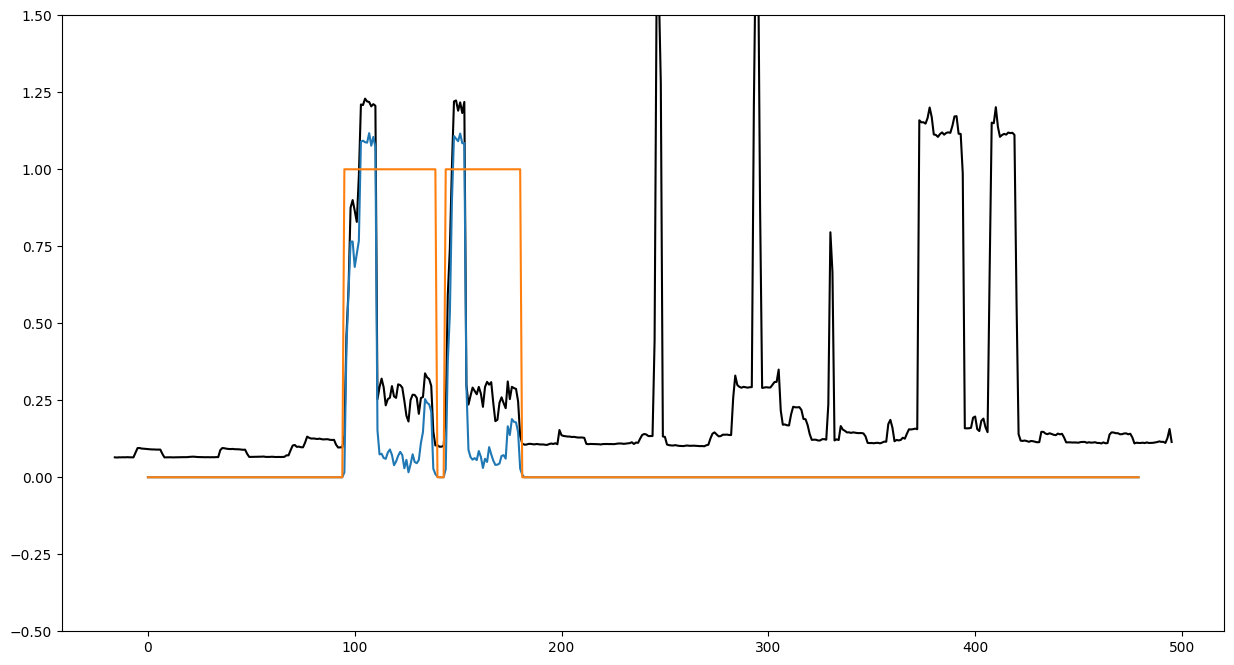

In [23]:
plt.figure(figsize=(15, 8))

# Assuming dataiter is a DataLoader object
for x, y, s in dataiter:
    if y[0, :, a].sum() > 0:
        break
    if s[0, :, a].sum() > 0:
        break

plt.plot(np.arange(-BORDER, SEQ_LEN + BORDER), x[0, :].detach().numpy(), 'k-')
plt.plot(y[0, :, a].detach().numpy())
plt.plot(s[0, :, a].detach().numpy())
plt.ylim([-0.5, 1.5])

In [24]:
batch_size = BATCH_SIZE
n_epochs = 300

train_loader = dl_train_seen
valid_loader = dl_valid_seen
test_loader = dl_test_seen

start_time_seen = time.perf_counter()

for i in range(20):
    
    print('TRAINING MODEL %d' % i)
    
    # Instantiate the model
    model = PTPNet(1,3,32).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1.E-4, weight_decay=1e-5)
    criterion = nn.L1Loss()

    fn = 'UKDALE_seen_power_PTPNet_%d.pth' % i
    
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, fn)

end_time_seen = time.perf_counter()

TRAINING MODEL 0
[  1/300] train_loss: 0.11224 valid_loss: 0.06110 test_loss: 0.06375 
Validation loss decreased (inf --> 0.061101).  Saving model ...
[  2/300] train_loss: 0.07292 valid_loss: 0.04413 test_loss: 0.04757 
Validation loss decreased (0.061101 --> 0.044135).  Saving model ...
[  3/300] train_loss: 0.05937 valid_loss: 0.03461 test_loss: 0.03784 
Validation loss decreased (0.044135 --> 0.034607).  Saving model ...
[  4/300] train_loss: 0.05070 valid_loss: 0.02954 test_loss: 0.03253 
Validation loss decreased (0.034607 --> 0.029541).  Saving model ...
[  5/300] train_loss: 0.04448 valid_loss: 0.02663 test_loss: 0.02978 
Validation loss decreased (0.029541 --> 0.026632).  Saving model ...
[  6/300] train_loss: 0.04039 valid_loss: 0.02422 test_loss: 0.02721 
Validation loss decreased (0.026632 --> 0.024220).  Saving model ...
[  7/300] train_loss: 0.03585 valid_loss: 0.02272 test_loss: 0.02552 
Validation loss decreased (0.024220 --> 0.022715).  Saving model ...
[  8/300] train

In [25]:
print(f"Time taken to train the model on seen dataset: {end_time_seen - start_time_seen} seconds")

Time taken to train the model on seen dataset: 5054.930106999993 seconds


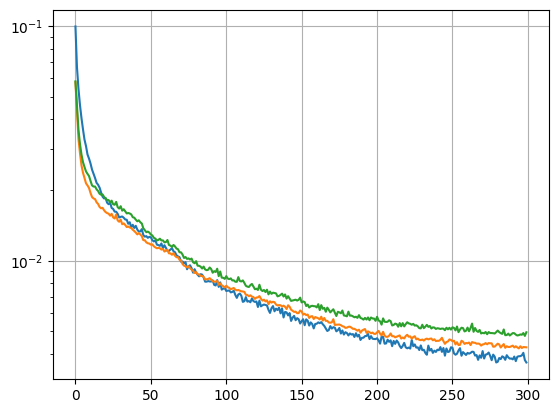

In [26]:
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.plot(test_loss, label='Test Loss')

plt.yscale('log')
plt.grid(True)

In [27]:
batch_size = BATCH_SIZE
n_epochs = 200

train_loader = dl_train_unseen
valid_loader = dl_valid_unseen
test_loader = dl_test_unseen

start_time_unseen = time.perf_counter()

for i in range(20):
    
    print('TRAINING MODEL %d' % i)
    
    # Instantiate the model
    model = PTPNet(1,3,32).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1.E-4, weight_decay=1e-5)
    criterion = nn.L1Loss()

    fn = 'UKDALE_unseen_power_PTPNet_%d.pth' % i
    
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, fn)

end_time_unseen = time.perf_counter()

TRAINING MODEL 0
[  1/200] train_loss: 0.11975 valid_loss: 0.06184 test_loss: 0.06255 
Validation loss decreased (inf --> 0.061839).  Saving model ...
[  2/200] train_loss: 0.06973 valid_loss: 0.04588 test_loss: 0.04241 
Validation loss decreased (0.061839 --> 0.045881).  Saving model ...
[  3/200] train_loss: 0.05643 valid_loss: 0.03790 test_loss: 0.03555 
Validation loss decreased (0.045881 --> 0.037900).  Saving model ...
[  4/200] train_loss: 0.04858 valid_loss: 0.03244 test_loss: 0.02892 
Validation loss decreased (0.037900 --> 0.032443).  Saving model ...
[  5/200] train_loss: 0.04205 valid_loss: 0.02985 test_loss: 0.02682 
Validation loss decreased (0.032443 --> 0.029854).  Saving model ...
[  6/200] train_loss: 0.03753 valid_loss: 0.02682 test_loss: 0.02326 
Validation loss decreased (0.029854 --> 0.026819).  Saving model ...
[  7/200] train_loss: 0.03405 valid_loss: 0.02596 test_loss: 0.02251 
Validation loss decreased (0.026819 --> 0.025960).  Saving model ...
[  8/200] train

In [28]:
print(f"Time taken to train the model on unseen dataset: {end_time_unseen - start_time_unseen} seconds")

Time taken to train the model on unseen dataset: 3521.315964399997 seconds


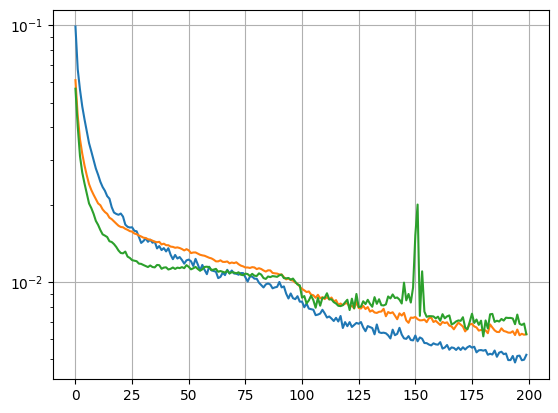

In [29]:
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.plot(test_loss, label='Test Loss')

plt.yscale('log')
plt.grid(True)

In [30]:
model = PTPNet(1,3,32).cuda()
model.eval()

PTPNet(
  (encoder1): Encoder(
    (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Encoder(
    (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Encoder(
    (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder4): Encoder(
    (conv): Conv1d(128,

# Load Power Models

In [31]:
# seen 10 18
# unseen 13

In [32]:
p_hat_appliances_seen = []

thr = 0.5

for i in range(1):
    filename = 'UKDALE_seen_power_PTPNet_14.pth'
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, p_hat = evaluate_power(model, dl_house_test[0], a)
        p_hat_appliances_seen.append(p_hat)

UKDALE_seen_power_PTPNet_14.pth


In [33]:
p_hat_appliances_unseen = []

thr = 0.5
for i in range(1):
    filename = 'UKDALE_unseen_power_PTPNet_10.pth'

    print(filename)
    model.load_state_dict(torch.load(filename))
    for  a in range(3):
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, p_hat = evaluate_power(model, dl_house_total[1], a)
        p_hat_appliances_unseen.append(p_hat)

UKDALE_unseen_power_PTPNet_10.pth


In [34]:
SEQ_LEN = 60*8
BORDER = 16
BATCH_SIZE = 32

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def r_squared_(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean)**2)
    ss_res = np.sum((y_true - y_pred)**2)

    epsilon = 1e-10
    if ss_tot == 0:
        ss_tot = epsilon
    
    return 1 - (ss_res / ss_tot)

In [36]:
# APPLIANCE = ['fridge', 'dish_washer', 'washing_machine']

mae = {}
mse = {}
rmse = {}
r_squared = {}

In [37]:
def calculate_energy(data_normalized, y_predicted, y_actual, window):
    # aggregate, power_appliances, status_appliances = ds_house_test[house][num_window]
    
    aggregate, _, _ = data_normalized[window] # 1 number of window
    total_predicted_power = sum(y_predicted)
    total_actual_power = sum(y_actual)

    predict_percentage = total_predicted_power / sum(aggregate)
    actual_percentage = total_actual_power / sum(aggregate)

    temp = copy.deepcopy(data_normalized)
    temp.denormalize()
    
    aggregate, _, _ = temp[window]
    
    actual_consumed = actual_percentage * sum(aggregate) / 1000
    predicted_consumed = predict_percentage * sum(aggregate) / 1000

    return sum(aggregate) / 1000, actual_consumed, predicted_consumed


def r_squared_(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean)**2)
    ss_res = np.sum((y_true - y_pred)**2)

    epsilon = 1e-10
    if ss_tot == 0:
        ss_tot = epsilon
    
    return 1 - (ss_res / ss_tot)

In [38]:
def apply_test_power(ds, p_hat, appliance=0, break_when=0, type='seen'):
    app = ""
    
    dataiter = iter(ds)

    cnt = 0

    break_index = None
    for idx, (x, y, s) in enumerate(dataiter):
        if y[0, :, appliance].sum() > 0 and cnt >= break_when:
            y_actual = y.permute(0,2,1)[:,appliance,:][0].contiguous().view(-1).detach().cpu().numpy()
            break_index = idx
            break
        cnt += 1
        
    print("Break index:", break_index)

    # p_hat[doesn't matter][break_index][idk][APPLIANCE]
    y_predicted = p_hat[0][break_index][0][appliance].contiguous().view(-1).detach().cpu().numpy()

    if appliance == 0:
        mae['fridge'] = mean_absolute_error(y_actual, y_predicted)
        mse['fridge'] = mean_squared_error(y_actual, y_predicted)
        rmse['fridge'] = np.sqrt(mse['fridge'])
        r_squared['fridge'] = r_squared_(y_actual, y_predicted)
        app = "Fridge"
    elif appliance == 1:
        mae['dish_washer'] = mean_absolute_error(y_actual, y_predicted)
        mse['dish_washer'] = mean_squared_error(y_actual, y_predicted)
        rmse['dish_washer'] = np.sqrt(mse['dish_washer'])
        r_squared['dish_washer'] = r_squared_(y_actual, y_predicted)
        app = "Dish Washer"
    elif appliance == 2:
        mae['washing_machine'] = mean_absolute_error(y_actual, y_predicted)
        mse['washing_machine'] = mean_squared_error(y_actual, y_predicted)
        rmse['washing_machine'] = np.sqrt(mse['washing_machine'])
        r_squared['washing_machine'] = r_squared_(y_actual, y_predicted)
        app = "Washing Machine"

    # Calculate the error
    error = y_predicted - y_actual

    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(-BORDER, SEQ_LEN + BORDER), x.contiguous().view(-1).detach().cpu().numpy(), label='Aggregate Power')
    plt.plot(y_actual, label='Actual')
    plt.plot(y_predicted, label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Actual Power vs Predicted Power [{app} {type}]')
    plt.legend()
    plt.show()
    
    total_aggregate_energy, actual_consumed_energy, predicted_consumed_energy = calculate_energy(ds_house_test[0], y_predicted, y_actual, break_index)

    print(f"Total Aggregate Energy is {total_aggregate_energy:.2f}kw/8h\n"
      f"Actual Energy Consumed by the {app} is {actual_consumed_energy:.2f}kw/8h\n"
      f"Predicted Energy Consumed by the {app} is {predicted_consumed_energy:.2f}kw/8h")

# House 1 seen For Fridge

Break index: 0


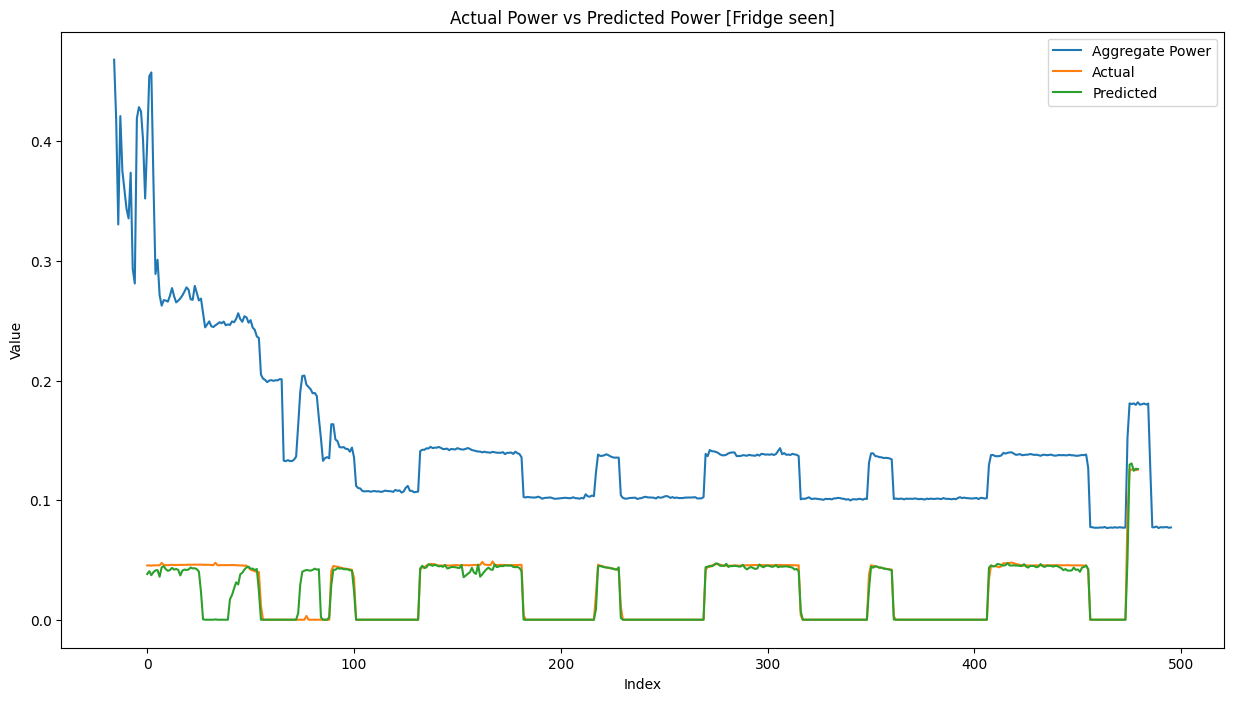

Total Aggregate Energy is 150.71kw/8h
Actual Energy Consumed by the Fridge is 22.72kw/8h
Predicted Energy Consumed by the Fridge is 21.12kw/8h


In [39]:
apply_test_power(dl_house_test[0], p_hat_appliances_seen)

# House 1 seen For Dish Washer

Break index: 3


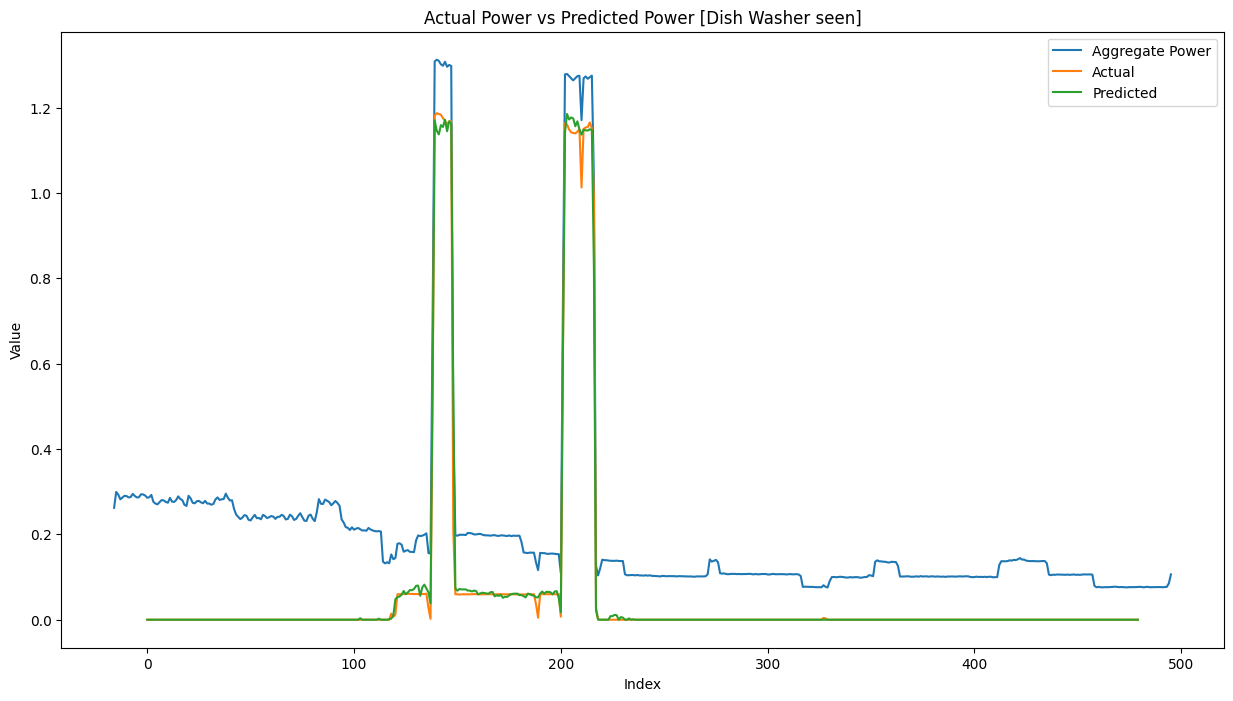

Total Aggregate Energy is 216.96kw/8h
Actual Energy Consumed by the Dish Washer is 65.71kw/8h
Predicted Energy Consumed by the Dish Washer is 67.13kw/8h


In [40]:
apply_test_power(dl_house_test[0], p_hat_appliances_seen, 1)

# House 1 seen For Washing Machine

Break index: 1


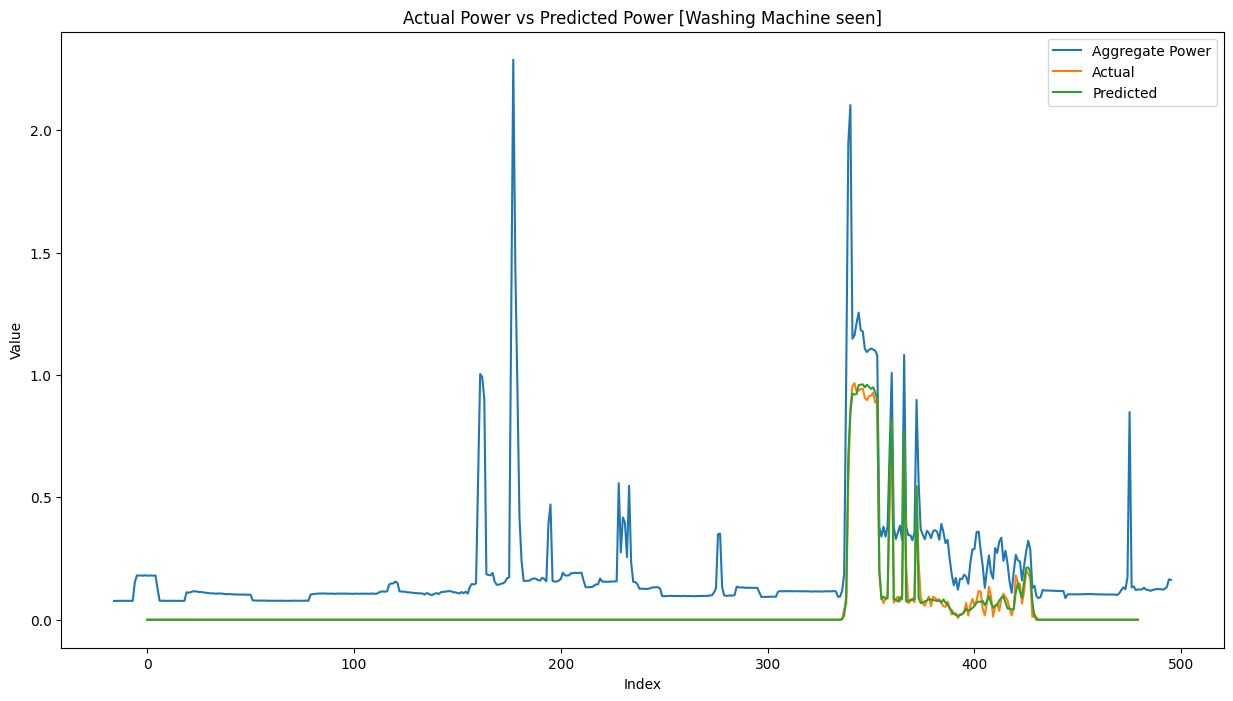

Total Aggregate Energy is 211.14kw/8h
Actual Energy Consumed by the Washing Machine is 43.91kw/8h
Predicted Energy Consumed by the Washing Machine is 44.32kw/8h


In [41]:
apply_test_power(dl_house_test[0], p_hat_appliances_seen, 2, 1)

In [42]:
print(f"fridge\nMAE  :{mae['fridge']}\nMSE  :{mse['fridge']}\nRMSE  :{rmse['fridge']}\nR Squared  :{r_squared['fridge']}")
print(f"\ndish_washer\nMAE  :{mae['dish_washer']}\nMSE  :{mse['dish_washer']}\nRMSE  :{rmse['dish_washer']}\nR Squared  :{r_squared['dish_washer']}")
print(f"\nwashing_machine\nMAE  :{mae['washing_machine']}\nMSE  :{mse['washing_machine']}\nRMSE  :{rmse['washing_machine']}\nR Squared  :{r_squared['washing_machine']}")

fridge
MAE  :0.003587055951356888
MSE  :0.00010567851859377697
RMSE  :0.010280005633831024
R Squared  :0.8285316228866577

dish_washer
MAE  :0.003578596282750368
MSE  :0.00035551696782931685
RMSE  :0.018855158239603043
R Squared  :0.9943731389939785

washing_machine
MAE  :0.004715790040791035
MSE  :0.00027398887323215604
RMSE  :0.016552608460187912
R Squared  :0.9903100822120905


# Differnet Window on seen data

In [43]:
mae = {}
mse = {}
rmse = {}
r_squared = {}

Break index: 6


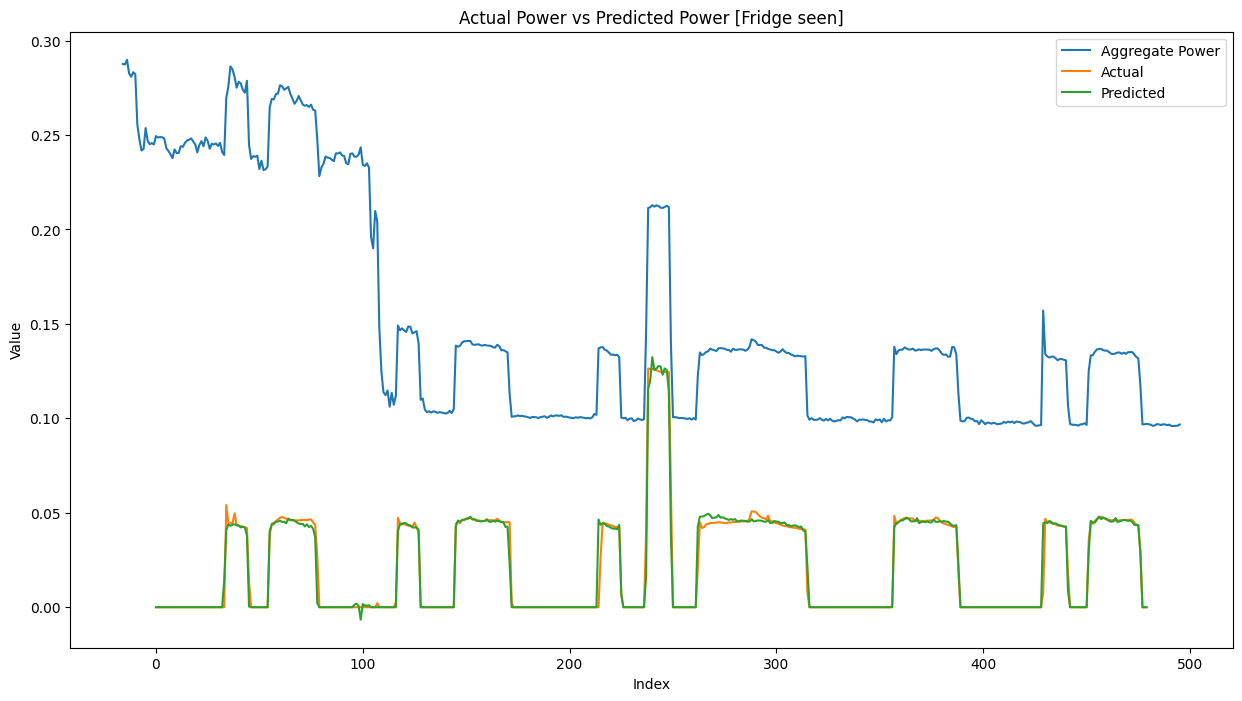

Total Aggregate Energy is 155.00kw/8h
Actual Energy Consumed by the Fridge is 21.36kw/8h
Predicted Energy Consumed by the Fridge is 21.26kw/8h


In [44]:
apply_test_power(dl_house_test[0], p_hat_appliances_seen, 0, 6)

Break index: 12


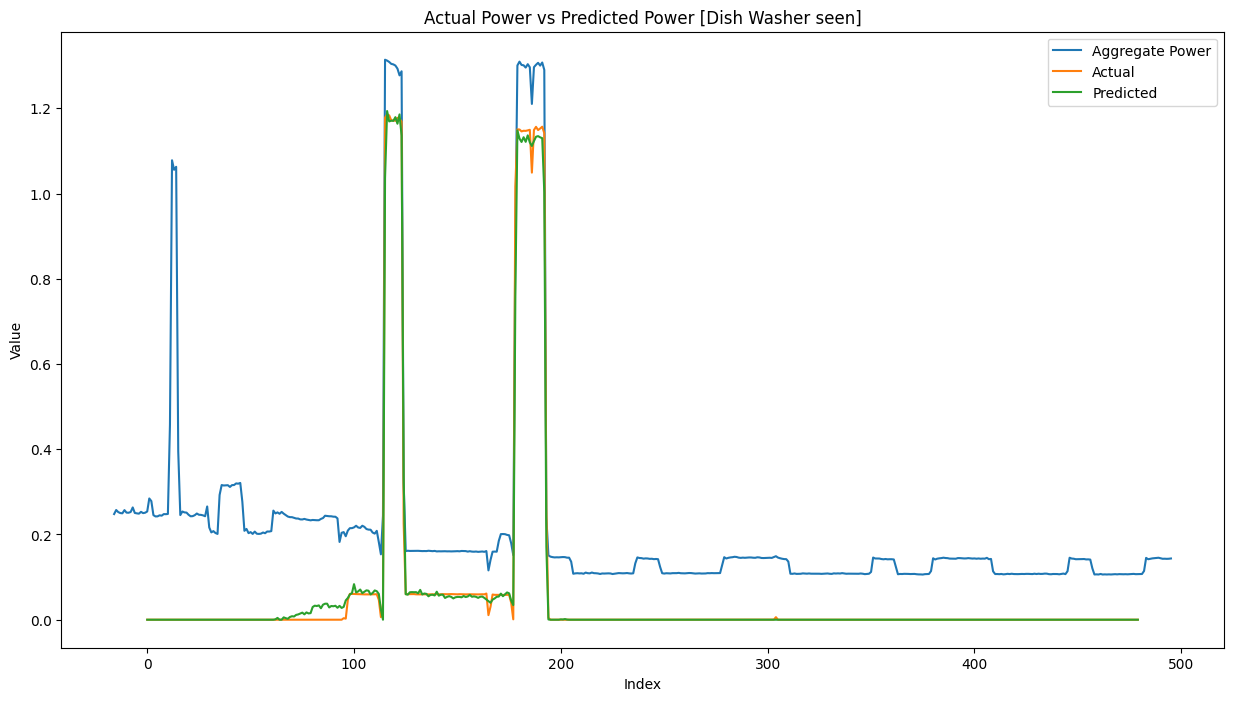

Total Aggregate Energy is 222.44kw/8h
Actual Energy Consumed by the Dish Washer is 64.13kw/8h
Predicted Energy Consumed by the Dish Washer is 64.12kw/8h


In [45]:
apply_test_power(dl_house_test[0], p_hat_appliances_seen, 1, 10)

Break index: 11


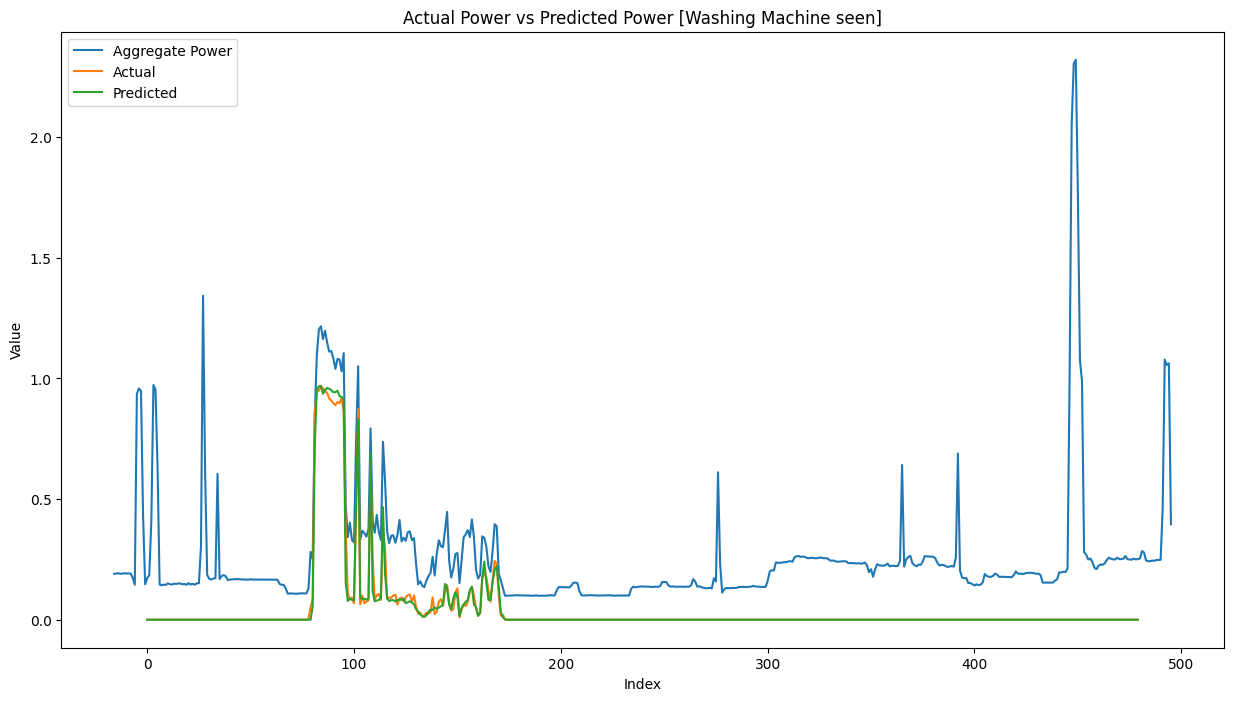

Total Aggregate Energy is 276.04kw/8h
Actual Energy Consumed by the Washing Machine is 45.98kw/8h
Predicted Energy Consumed by the Washing Machine is 45.05kw/8h


In [46]:
apply_test_power(dl_house_test[0], p_hat_appliances_seen, 2, 10)

In [47]:
print(f"fridge\nMAE  :{mae['fridge']}\nMSE  :{mse['fridge']}\nRMSE  :{rmse['fridge']}\nR Squared  :{r_squared['fridge']}")
print(f"\ndish_washer\nMAE  :{mae['dish_washer']}\nMSE  :{mse['dish_washer']}\nRMSE  :{rmse['dish_washer']}\nR Squared  :{r_squared['dish_washer']}")
print(f"\nwashing_machine\nMAE  :{mae['washing_machine']}\nMSE  :{mse['washing_machine']}\nRMSE  :{rmse['washing_machine']}\nR Squared  :{r_squared['washing_machine']}")

fridge
MAE  :0.0012797177769243717
MSE  :1.7697038856567815e-05
RMSE  :0.004206785000860691
R Squared  :0.9758268687874079

dish_washer
MAE  :0.004861275665462017
MSE  :0.00034214730840176344
RMSE  :0.018497224897146225
R Squared  :0.9945188057608902

washing_machine
MAE  :0.005048015154898167
MSE  :0.0003304128476884216
RMSE  :0.01817726157605648
R Squared  :0.9886728813871741


# Unseen Evaluation


In [48]:
mae_unseen = {}
mse_unseen = {}
r_squared_unseen = {}

# House 2 unseen For Fridge "Power Prediction"

Break index: 1


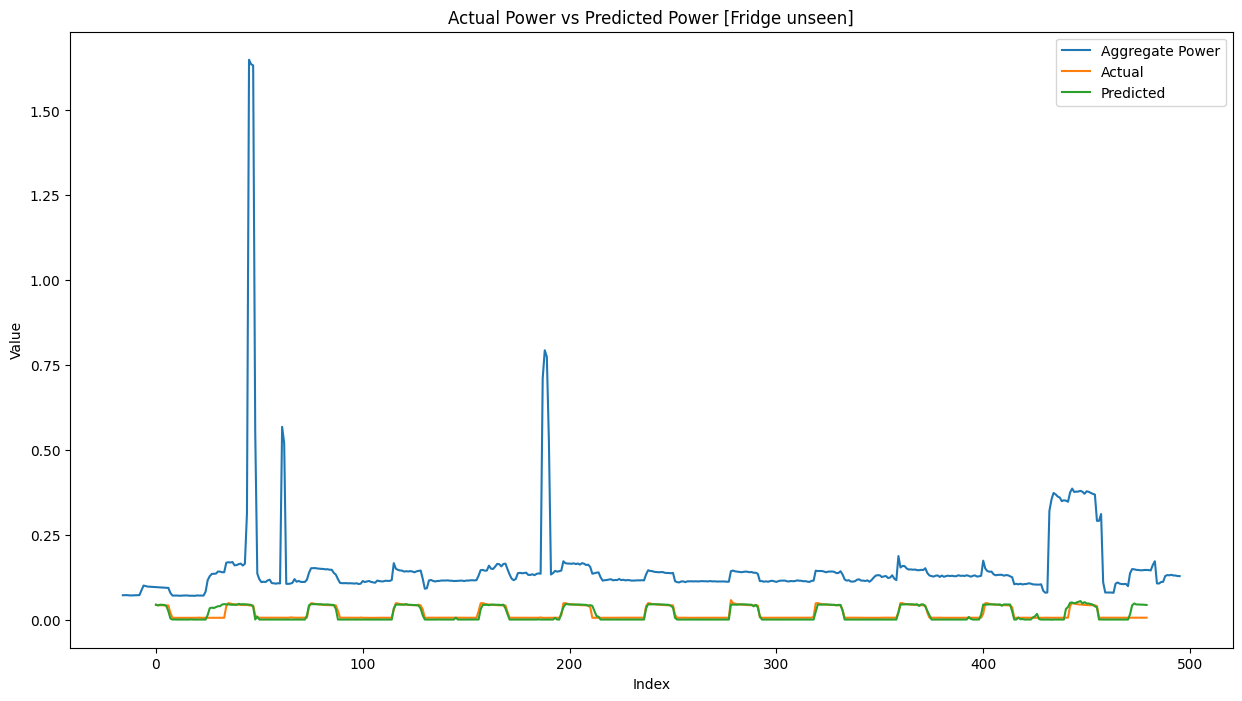

Total Aggregate Energy is 211.14kw/8h
Actual Energy Consumed by the Fridge is 17.62kw/8h
Predicted Energy Consumed by the Fridge is 15.91kw/8h


In [49]:
apply_test_power(dl_house_total[1], p_hat_appliances_unseen, 0, 1, 'unseen')

# House 2 unseen For Dish Washer "Power Prediction"

Break index: 5


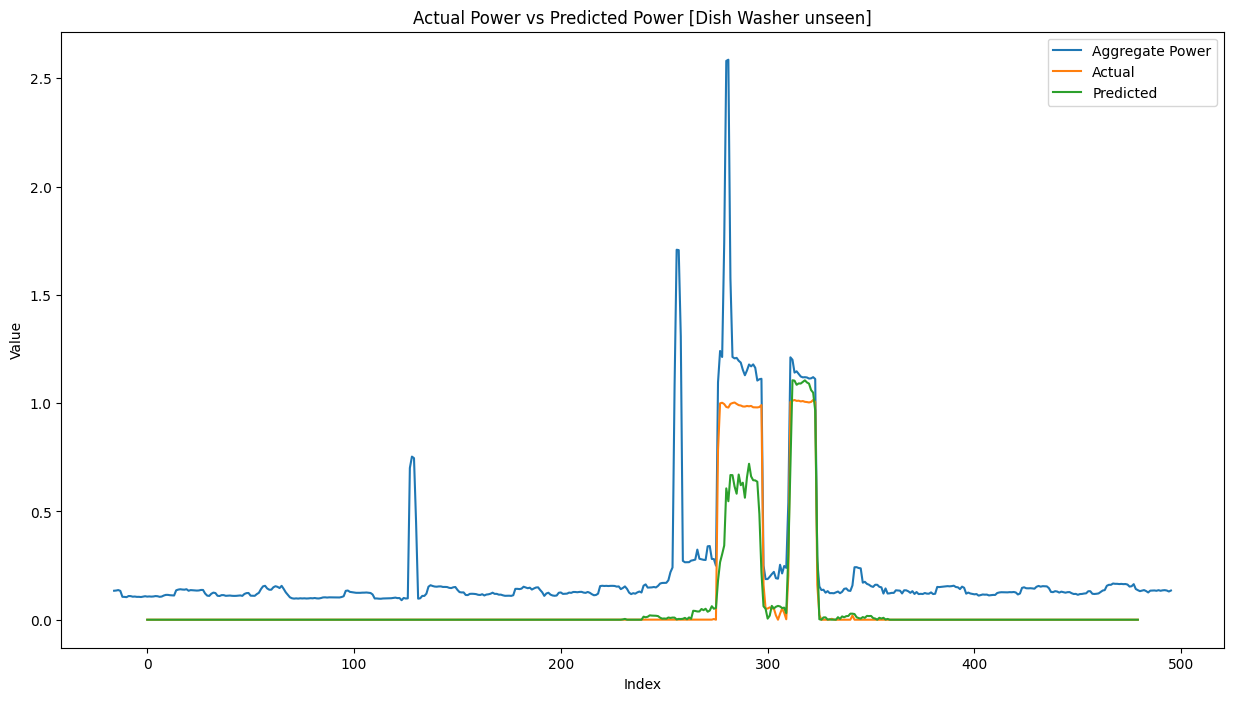

Total Aggregate Energy is 226.87kw/8h
Actual Energy Consumed by the Dish Washer is 71.28kw/8h
Predicted Energy Consumed by the Dish Washer is 55.72kw/8h


In [50]:
apply_test_power(dl_house_total[1], p_hat_appliances_unseen, 1, 3, 'unseen')

# House 2 unseen For Washing Machine "Power Prediction"

Break index: 13


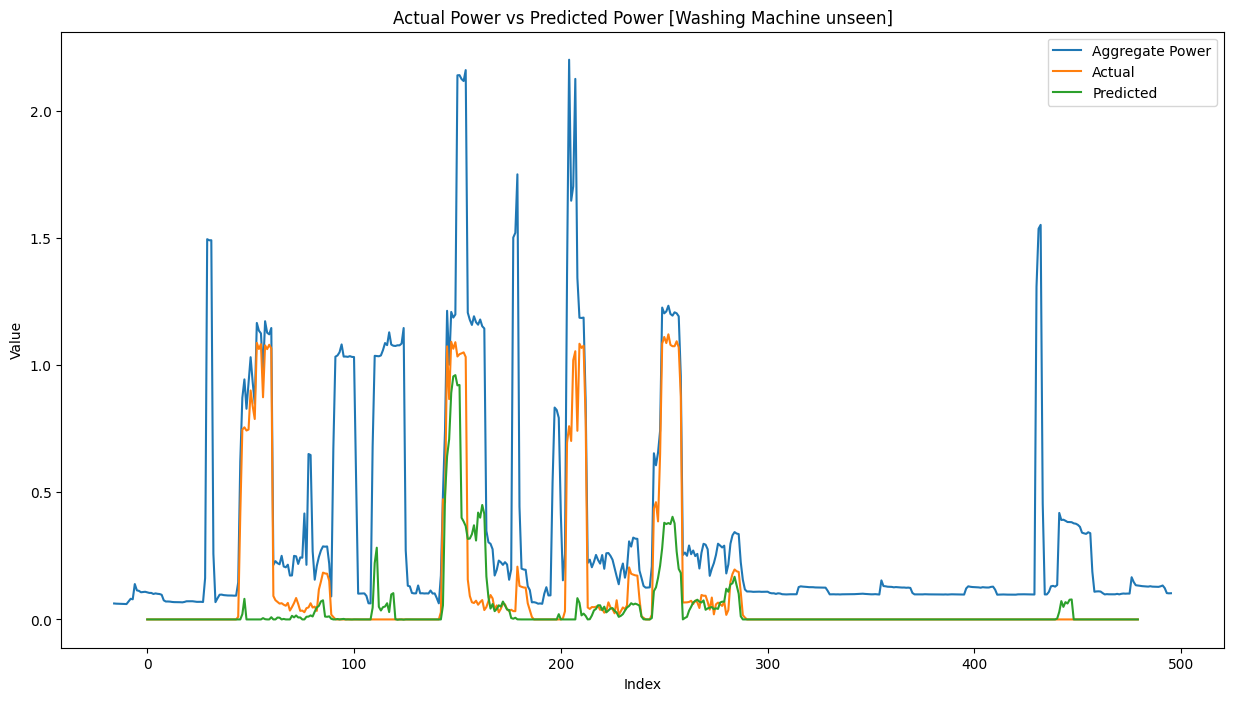

Total Aggregate Energy is 185.86kw/8h
Actual Energy Consumed by the Washing Machine is 112.36kw/8h
Predicted Energy Consumed by the Washing Machine is 41.63kw/8h


In [51]:
apply_test_power(dl_house_total[1], p_hat_appliances_unseen, 2, 3, 'unseen')

In [52]:
print(f"fridge\nMAE  :{mae['fridge']}\nMSE  :{mse['fridge']}\nRMSE  :{rmse['fridge']}\nR Squared  :{r_squared['fridge']}")
print(f"\ndish_washer\nMAE  :{mae['dish_washer']}\nMSE  :{mse['dish_washer']}\nRMSE  :{rmse['dish_washer']}\nR Squared  :{r_squared['dish_washer']}")
print(f"\nwashing_machine\nMAE  :{mae['washing_machine']}\nMSE  :{mse['washing_machine']}\nRMSE  :{rmse['washing_machine']}\nR Squared  :{r_squared['washing_machine']}")

fridge
MAE  :0.005877479910850525
MSE  :8.059209358179942e-05
RMSE  :0.008977309800684452
R Squared  :0.7508131116628647

dish_washer
MAE  :0.026185283437371254
MSE  :0.010289785452187061
RMSE  :0.10143858194351196
R Squared  :0.8449403047561646

washing_machine
MAE  :0.09319838136434555
MSE  :0.06351472437381744
RMSE  :0.25202128291130066
R Squared  :0.23344218730926514


# Differnet Window on unseen data

In [53]:
mae = {}
mse = {}
rmse = {}
r_squared = {}

Break index: 10


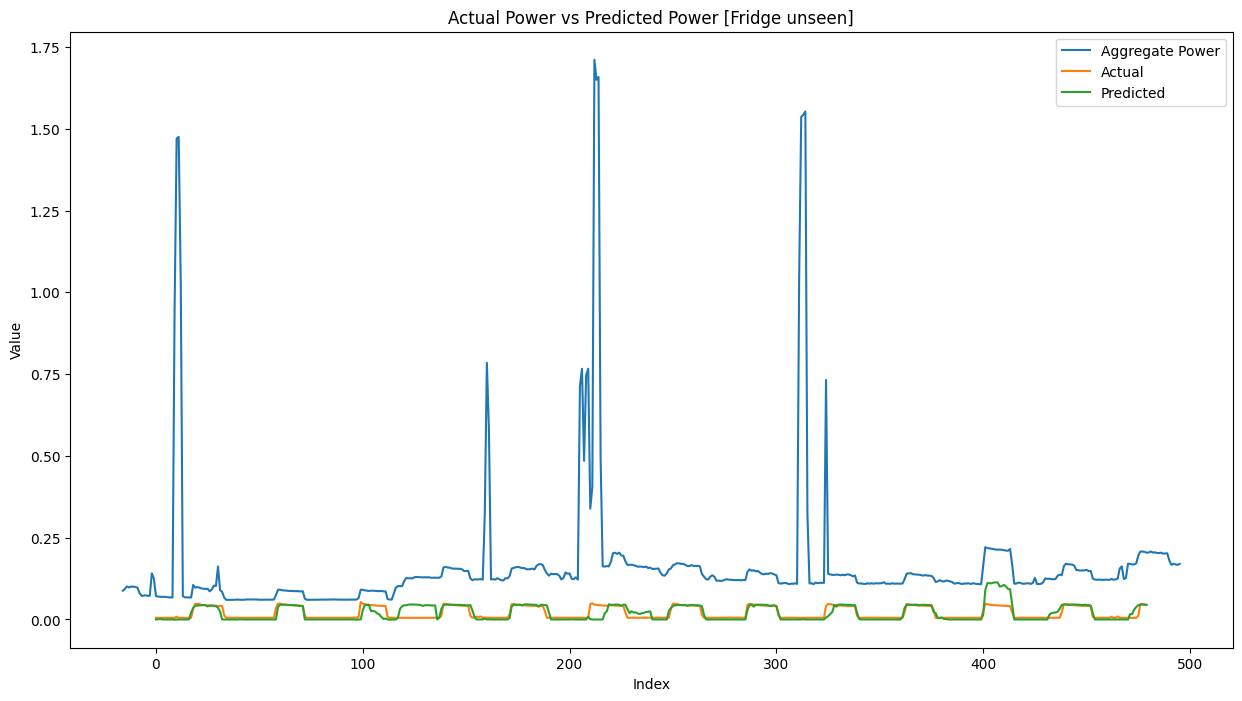

Total Aggregate Energy is 180.23kw/8h
Actual Energy Consumed by the Fridge is 19.04kw/8h
Predicted Energy Consumed by the Fridge is 19.32kw/8h


In [54]:
apply_test_power(dl_house_total[1], p_hat_appliances_unseen, 0, 10, 'unseen')

Break index: 11


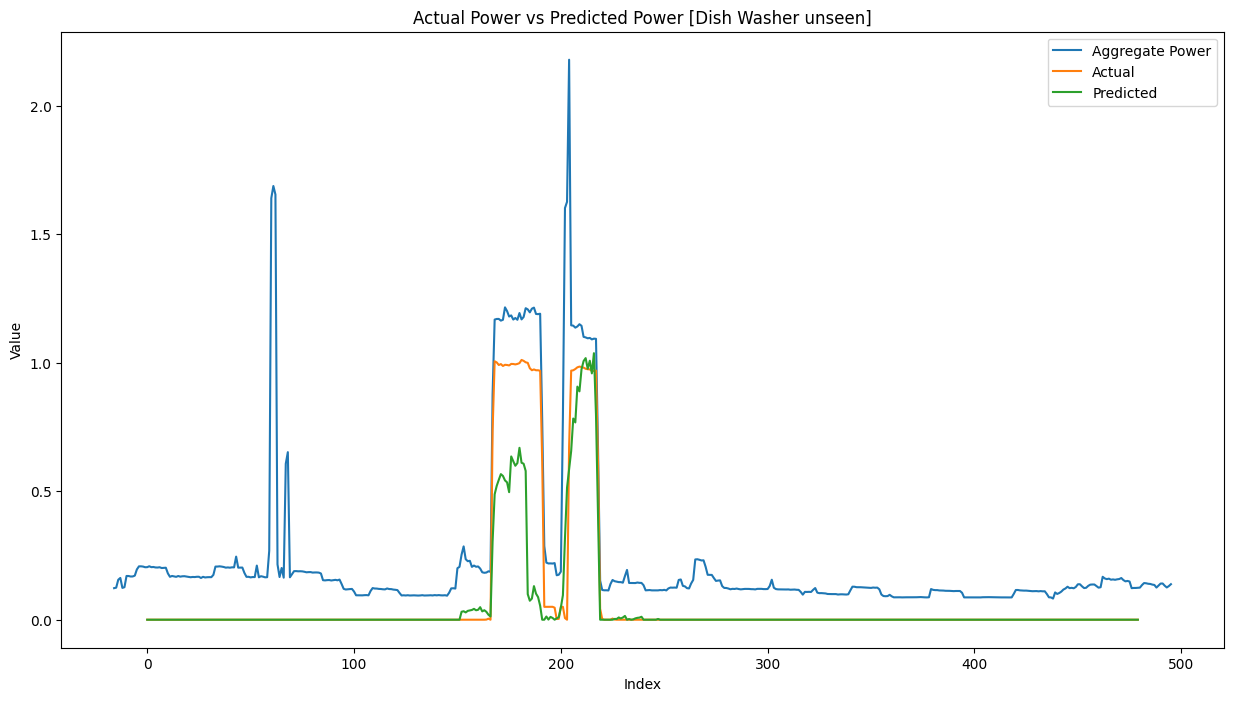

Total Aggregate Energy is 276.04kw/8h
Actual Energy Consumed by the Dish Washer is 77.12kw/8h
Predicted Energy Consumed by the Dish Washer is 48.95kw/8h


In [55]:
apply_test_power(dl_house_total[1], p_hat_appliances_unseen, 1, 10, 'unseen')

Break index: 13


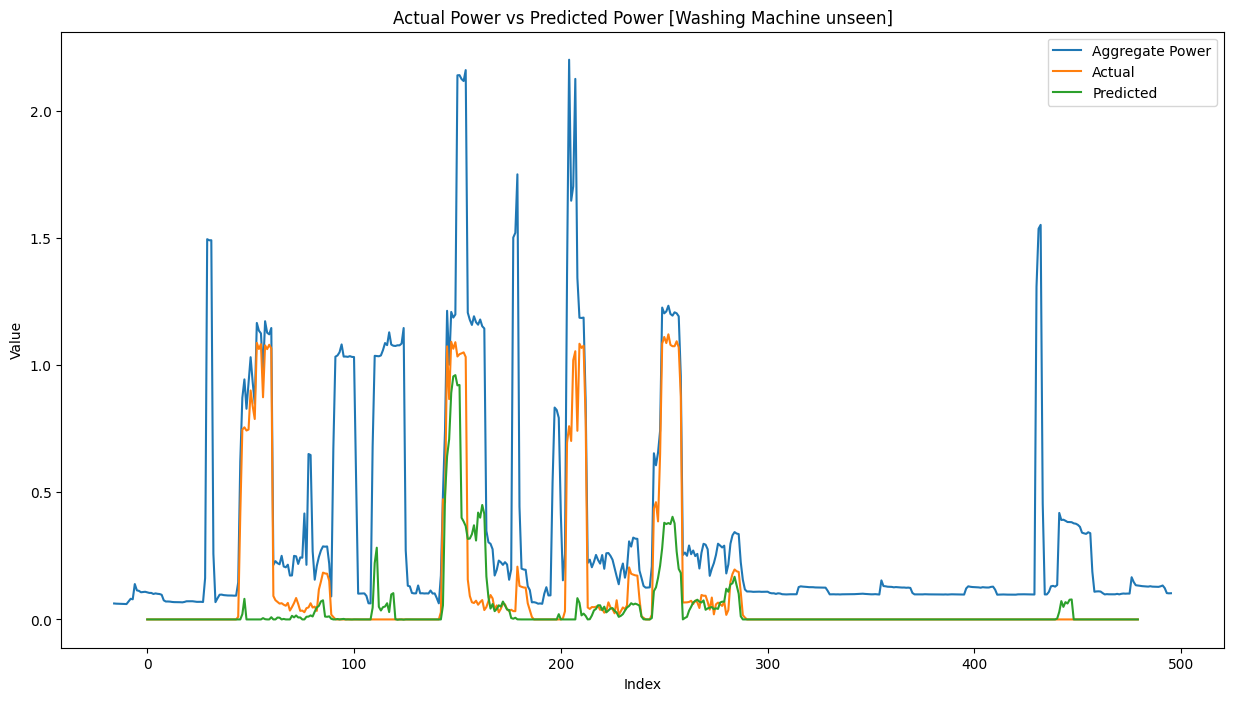

Total Aggregate Energy is 185.86kw/8h
Actual Energy Consumed by the Washing Machine is 112.36kw/8h
Predicted Energy Consumed by the Washing Machine is 41.63kw/8h


In [56]:
apply_test_power(dl_house_total[1], p_hat_appliances_unseen, 2, 10, 'unseen')

In [57]:
print(f"fridge\nMAE  :{mae['fridge']}\nMSE  :{mse['fridge']}\nRMSE  :{rmse['fridge']}\nR Squared  :{r_squared['fridge']}")
print(f"\ndish_washer\nMAE  :{mae['dish_washer']}\nMSE  :{mse['dish_washer']}\nRMSE  :{rmse['dish_washer']}\nR Squared  :{r_squared['dish_washer']}")
print(f"\nwashing_machine\nMAE  :{mae['washing_machine']}\nMSE  :{mse['washing_machine']}\nRMSE  :{rmse['washing_machine']}\nR Squared  :{r_squared['washing_machine']}")

fridge
MAE  :0.00978526659309864
MSE  :0.00027516798581928015
RMSE  :0.01658818870782852
R Squared  :0.1825304627418518

dish_washer
MAE  :0.036120783537626266
MSE  :0.02009369060397148
RMSE  :0.1417522132396698
R Squared  :0.7130310237407684

washing_machine
MAE  :0.09319838136434555
MSE  :0.06351472437381744
RMSE  :0.25202128291130066
R Squared  :0.23344218730926514
